In [2]:
import pandas as pd
import numpy as np
import geopy
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Donor-Advised Fund Tracker
##### Exploratory Data Analysis 
----
This project aims to analyze and map the flow of funds from donor-advised funds to nonprofit organizations, as well as demonstrate a sustainable open-source information project for the nonprofit sector.

In [3]:
grantees = pd.read_csv('Grantees.csv')

C:\Users\Jacob\miniconda3\envs\mlearn\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
sponsors = pd.read_csv('Sponsors.csv')

In [5]:
print('Number of nonunique grantee organizations: ', grantees.shape[0])
print('Number of sponsoring organizations: ', sponsors.shape[0])

Number of nonunique grantee organizations:  192298
Number of sponsoring organizations:  1107


The *sponsors* dataframe indicates the sponsoring organizations of any donor-advised funds, and the *grantees* dataframe aggregates information about the recipients. See [fields.csv](https://github.com/leppekja/IRS-990-DAFs/blob/master/fields.csv) as a reference for field descriptions.

In [6]:
sponsors.head()

,Unnamed: 0,EIN,NAME,AddressLine1Txt,CityNm,StateAbbreviationCd,ZIPCd,DonorAdvisedFundsHeldCnt,DonorAdvisedFundsContriAmt,DonorAdvisedFundsGrantsAmt,DonorAdvisedFundsVlEOYAmt,DisclosedOrgLegCtrlInd,DisclosedForCharitablePrpsInd,FundsAndOtherAccountsHeldCnt,FundsAndOtherAccountsContriAmt,FundsAndOtherAccountsGrantsAmt,FundsAndOtherAccountsVlEOYAmt
0,0,391869271,THE WILLIAM J AND BARBARA A SCHMIDT,4455 W LAWRENCE ST,APPLETON,WI,54914,5.0,404300.0,308393.0,429877.0,1,1,1.0,1565974.0,245680.0,6293171.0
1,0,626047769,AMERICAN INSTITUTE OF ARCHITECTS,511 south main street,MEMPHIS,TN,38103,1.0,NaN,NaN,403.0,0,0,NaN,NaN,NaN,NaN
2,0,237414842,ROTARY CLUB OF LAKE HICKORY,PO BOX 9104,HICKORY,NC,28603,1.0,NaN,18471.0,126699.0,1,1,NaN,9053.0,22500.0,NaN
3,0,470700795,OMAHA COMMUNITY PLAYHOUSE FOUNDATION,6915 CASS STREET,OMAHA,NE,681322649,1.0,NaN,NaN,152079.0,1,1,NaN,NaN,NaN,NaN
4,0,943331010,JustGive Inc,830 Menlo Ave No 100,Menlo Park,CA,94025,1.0,28215599.0,28300230.0,2301018.0,1,1,NaN,NaN,NaN,NaN


In [7]:
grantees.head()

,Unnamed: 0,BusinessNameLine1Txt,AddressLine1Txt,AddressLine2Txt,CityNm,StateAbbreviationCd,ZIPCd,RecipientEIN,IRCSectionDesc,CashGrantAmt,...,Sponsor,GrantTypeTxt,RecipientCnt,NonCashAssistanceDesc,ValuationMethodUsedDesc,NonCashAssistanceAmt,ProvinceOrStateNm,CountryCd,ForeignPostalCd,BusinessNameLine2Txt
0,1,ANN & ROBERT H LURIE CHILDREN'S HOSPITAL OF CH...,2300 CHILDRENS MEMORIAL PLAZA BOX 4,4,CHICAGO,IL,606143394.0,362170833.0,501C3,25000.0,...,391869271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,CASA ESTHER,107 SOUTH WEBSTER AVENUE,NaN,OMRO,WI,54963.0,262572419.0,501C3,15000.0,...,391869271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,CATALPA HEALTH,444 NORTH WESTHILL BLVD,NaN,APPLETON,WI,54914.0,454681563.0,501C3,20000.0,...,391869271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,CHIARAVALLE MONTESSORI SCHOOL,425 DEMPSTER ST,NaN,EVANSTON,IL,60201.0,362580506.0,501C3,20000.0,...,391869271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,CHICAGO CUBS CHARITIES,1060 WEST ADDISON STREET,NaN,CHICAGO,IL,60613.0,363443543.0,501C3,10000.0,...,391869271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning
Both dataframes:

- remove Unnamed:0 index column
- 8 digit zip codes to 5 
- Check state abbreviations, address standardization

grantees.csv

- remove trailing zero on ZIPCd, RecipientEIN,

In [8]:
grantees.drop(['Unnamed: 0'], axis=1, inplace=True)
sponsors.drop(['Unnamed: 0'], axis=1, inplace=True)

grantees['ZIPCd'] = grantees['ZIPCd'].astype(str).str[:5]
sponsors['ZIPCd'] = sponsors['ZIPCd'].astype(str).str[:5]

# Grantees may be school districts, meaning no EIN
grantees['RecipientEIN'].fillna(-1, inplace=True)
grantees['RecipientEIN'] = grantees['RecipientEIN'].astype(int)

### Data Visualizations
----
- how many nonprofit organizations supported by each sponsor bar chart
- how much funding given by each sponsor bar chart
- aggregate income into daf for each sponsor bar chart
- how much funding recieved by each nonprofit organization bar chart
- functions for mapping sponsors outgoing funds
- functions for mapping grantee's incoming funds

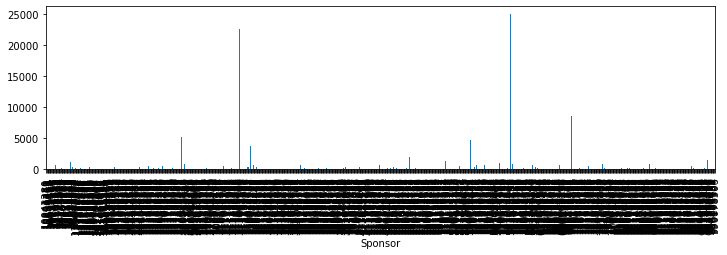

In [9]:
fig, ax = plt.subplots(figsize=(12,3))
grantees.groupby('Sponsor')['RecipientEIN'].count().plot(kind='bar', ax=ax)

In [10]:
grantees['RecipientEIN'].nunique()

88785

In [47]:
sponsors.DonorAdvisedFundsHeldCnt.sum()

4008317.0

In [59]:
def frequency(data, columns):
    '''
    Displays general visualizations to explore data
    '''
    fig, axs = plt.subplots(len(columns), figsize=(15,4), sharex=False)
    fig.subplots_adjust(hspace=1)
    plt.suptitle("Frequency and Proportions of " + ", ".join(columns))
    axes_iterator = ([axs] if len(columns) == 1 else axs.flatten())
    for ax, col in zip(axes_iterator, columns):
        twin = ax.twinx()
        ax.bar(data[col].value_counts().index, data[col].value_counts().values)
        twin.plot(np.cumsum(data[col].value_counts(normalize=True)), c='r')
        twin.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right', fontsize=12)
        ax.set_ylabel('Frequency')
        twin.set_ylabel('Proportion')
        ax.grid(b=True, which='major')
        ax.set_axisbelow(b=True)
    
    plt.show()

In [65]:
sponsors[sponsors['DonorAdvisedFundsHeldCnt'] == sponsors['DonorAdvisedFundsHeldCnt'].max()]

,EIN,NAME,AddressLine1Txt,CityNm,StateAbbreviationCd,ZIPCd,DonorAdvisedFundsHeldCnt,DonorAdvisedFundsContriAmt,DonorAdvisedFundsGrantsAmt,DonorAdvisedFundsVlEOYAmt,DisclosedOrgLegCtrlInd,DisclosedForCharitablePrpsInd,FundsAndOtherAccountsHeldCnt,FundsAndOtherAccountsContriAmt,FundsAndOtherAccountsGrantsAmt,FundsAndOtherAccountsVlEOYAmt
388,133392711,FRIENDS OF ISRAEL DISABLED VETERANS INC,1133 BROADWAY NO 232,NEW YORK,NY,10010,2884298.0,2650330.0,3492095.0,NaN,0,1,NaN,NaN,NaN,NaN


In [81]:
sponsors.iloc[sponsors['DonorAdvisedFundsHeldCnt'].nlargest(10).index]

,EIN,NAME,AddressLine1Txt,CityNm,StateAbbreviationCd,ZIPCd,DonorAdvisedFundsHeldCnt,DonorAdvisedFundsContriAmt,DonorAdvisedFundsGrantsAmt,DonorAdvisedFundsVlEOYAmt,DisclosedOrgLegCtrlInd,DisclosedForCharitablePrpsInd,FundsAndOtherAccountsHeldCnt,FundsAndOtherAccountsContriAmt,FundsAndOtherAccountsGrantsAmt,FundsAndOtherAccountsVlEOYAmt
388,133392711,FRIENDS OF ISRAEL DISABLED VETERANS INC,1133 BROADWAY NO 232,NEW YORK,NY,10010,2884298.0,2.650330e+06,3.492095e+06,NaN,0,1,NaN,NaN,NaN,NaN
386,680560974,BREMERTON SCHOOLS AND ALUMNI FOUNDATION,134 MARION AVE NORTH,BREMERTON,WA,98312,493583.0,1.143100e+04,NaN,5.050140e+05,1,1,40828.0,10140.0,NaN,50968.0
61,251604115,MERCY LIFE CENTER CORPORATION,1200 REEDSDALE STREET,PITTSBURGH,PA,15233,209182.0,NaN,NaN,2.091820e+05,1,1,NaN,NaN,NaN,NaN
865,821654140,TAIBA USA,1109 Conrad Sauer Dr Unit D,Houston,TX,77043,97275.0,3.000000e+05,0.000000e+00,9.727500e+04,0,1,0.0,0.0,0.0,0.0
971,450931286,PAYPAL CHARITABLE GIVING FUND,1250 I STREET NW NO 1202,WASHINGTON,DC,20005,78528.0,1.050133e+08,1.024004e+08,1.552216e+07,1,1,NaN,NaN,NaN,NaN
348,611043635,FEEDING AMERICA KENTUCKY'S HEARTLAND,PO BOX 821,ELIZABETHTOWN,KY,42702,47500.0,NaN,NaN,NaN,0,0,17034023.0,NaN,NaN,NaN
35,311640316,SCHWAB CHARITABLE FUND,211 MAIN STREET,SAN FRANCISCO,CA,94105,35798.0,3.078089e+09,1.565164e+09,1.061460e+10,1,1,NaN,NaN,NaN,NaN
744,363172605,FOOD ANIMAL CONCERNS TRUST,3525 W PETERSON AVE NO 213,CHICAGO,IL,60659,24426.0,8.066300e+04,NaN,NaN,0,0,948843.0,462448.0,NaN,NaN
438,581493949,NATL CHRISTIAN CHARITABLE FDN INC,11625 Rainwater Drive No 500,ALPHARETTA,GA,30009,18667.0,1.514477e+09,8.556053e+08,2.371019e+09,1,1,1703.0,18612839.0,216411594.0,14198809.0
56,262449481,GIVE BACK FOUNDATION,2302 INTERNATIONAL LANE,MADISON,WI,53704,17428.0,6.428910e+06,1.455466e+06,5.494996e+06,1,1,NaN,NaN,NaN,NaN


Quick geocoding test using the Census Bureau's [geocoding service](https://geocoding.geo.census.gov/geocoder/locations/addressbatch?form):

In [19]:
sponsor_addresses = sponsors.loc[:,['AddressLine1Txt','CityNm','StateAbbreviationCd','ZIPCd']].to_csv('sponsor_addresses.csv')
grantee_addresses_1 = grantees.loc[:9999,['AddressLine1Txt','CityNm','StateAbbreviationCd','ZIPCd']].to_csv('grantee_addresses_1.csv')
grantee_addresses_2 = grantees.loc[9999:,['AddressLine1Txt','CityNm','StateAbbreviationCd','ZIPCd']].to_csv('grantee_addresses_2.csv')


In [12]:
grantees.columns

Index(['BusinessNameLine1Txt', 'AddressLine1Txt', 'AddressLine2Txt', 'CityNm',
       'StateAbbreviationCd', 'ZIPCd', 'RecipientEIN', 'IRCSectionDesc',
       'CashGrantAmt', 'PurposeOfGrantTxt', 'Sponsor', 'GrantTypeTxt',
       'RecipientCnt', 'NonCashAssistanceDesc', 'ValuationMethodUsedDesc',
       'NonCashAssistanceAmt', 'ProvinceOrStateNm', 'CountryCd',
       'ForeignPostalCd', 'BusinessNameLine2Txt'],
      dtype='object')

In [20]:
grantees.shape

(192298, 20)

In [22]:
sponsors_locs = gpd.GeoDataFrame(pd.read_csv('sponsor_address_results.csv'))

In [23]:
sponsors_locs.head()

,,,,,Unnamed: 0,"AddressLine1Txt, CityNm, StateAbbreviationCd, ZIPCd",No_Match
0,"4455 W LAWRENCE ST, APPLETON, WI, 54914",Match,Non_Exact,"4455 W LAWRENCE ST, APPLETON, WI, 54914","-88.4728,44.260296",642900710.0,L
1,"511 south main street, MEMPHIS, TN, 38103",Match,Exact,"511 S MAIN ST, MEMPHIS, TN, 38103","-90.05898,35.133457",72903444.0,R
2,"PO BOX 9104, HICKORY, NC, 28603",No_Match,NaN,NaN,NaN,NaN,NaN
3,"6915 CASS STREET, OMAHA, NE, 68132",Match,Exact,"6915 CASS ST, OMAHA, NE, 68132","-96.01989,41.26327",117014370.0,L
4,"830 Menlo Ave No 100, Menlo Park, CA, 94025",Match,Non_Exact,"830 MENLO AVE, MENLO PARK, CA, 94025","-122.184235,37.449986",192365426.0,R


In [28]:
sponsors_locs['Unnamed: 0'].str.split(',')

0   4455 W LAWRENCE ST, APPLETON, WI, 54914          Match     Non_Exact  4455 W LAWRENCE ST, APPLETON, WI, 54914       [-88.4728, 44.260296]
1   511 south main street, MEMPHIS, TN, 38103        Match     Exact      511 S MAIN ST, MEMPHIS, TN, 38103            [-90.05898, 35.133457]
2   PO BOX 9104, HICKORY, NC, 28603                  No_Match  NaN        NaN                                                             NaN
3   6915 CASS STREET, OMAHA, NE, 68132               Match     Exact      6915 CASS ST, OMAHA, NE, 68132                [-96.01989, 41.26327]
4   830 Menlo Ave No 100, Menlo Park, CA, 94025      Match     Non_Exact  830 MENLO AVE, MENLO PARK, CA, 94025       [-122.184235, 37.449986]
                                                                                                                               ...           
95  300 SOUTHARD ST SUITE 201, KEY WEST, FL, 33040   Match     Exact      300 SOUTHARD ST, KEY WEST, FL, 33040         [-81.80419, 24.553507]
96  20